<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/Reto_Entrega_2_Equipo41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portada
---

<br>
<p align=center>Instituto Tecnológico y de Estudios Superiores de Monterrey</p>
<p align=center>Escuela de Ingeniería y Ciencias</p>
<p align=center>
<br>
<img src="https://github.com/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/tec.png?raw=true" alt="Logo" width="250"/>
</p>
<br>
<p align=center>Maestría en Inteligencia Artificial Aplicada (MNA)</p>
<p align=center>TC4029. Ciencia y Analítica de Datos</p>
<p align=center> Profesor Titular: María de la Paz Rico </p>
<p align=center> <b>Reto Final - Parte II (Modelo)</b> </p>
<br>
<p align=center>Presentan:</p>
<p align=center>A01150742 | Ovalle Alvarado José</p>
<p align=center>A01793023 | Arroyo Chavelas Jorge Luis</p>
<p align=center>18 de Noviembre de 2022</p>
<br>
<br>
<p align=center><small><italic>“Por medio de la presente hacemos constar que el reporte que estamos enviando es de nuestra completa autoría y que no estamos haciendo plagio de ideas o escritos del trabajo de otras personas”</italic></small></p>

---

[GitHub Link](https://github.com/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/Reto_Entrega_1_Equipo41.ipynb)


# Introducción

Este documento es una continuación del análsis realizado en la [entrega 1](https://github.com/PosgradoMNA/actividades-del-projecto-equipo-41/blob/main/Reto_Entrega_1_Equipo41.ipynb). Aquí trataremos de generar un modelo capaz de predecir al semáforo de calidad del agua basada en los datos que previamente análizamos.

Preapremos primero nuestro ambiente de análisis:

In [1]:
############################################################################################
# Librerias y funciones:
############################################################################################


# Para obtener los datos
import requests
import zipfile
import io



# Para manipualr datos
import pandas as pd
import numpy as np
import re
import random


# Para visualizaciones:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns



# Para particiones y validaciones
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate



# Para transformaciones:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder



# Para pipelines:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer



# Modelos de ML:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



# Para medir bondad de ajuste:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score



# Otras utilidades
import functools
import warnings
sns.set_theme(style='white', palette=None)
%matplotlib inline



# Transformador basado en análisis de la entrega 1
class NumericStrategy(BaseEstimator, TransformerMixin):
  """
    Esta clase toma un valor de contaminante numérica o pseudonumérica.
    Convierte todo a valores numéricos; cuando encuentra cadenas,
    extrae el texto de estas para ahcer el input; si no existen valores,
    lo pasa con nulos para que otros métodos generen el input.
  """
  def __init__(self):
    return None

  def fit(self, X=None, y=None):
    return self

  def transform(self, X=None, y=None):
    # Get all columns:
    cols = X.columns
    # Transform dataframe to numeric:
    X_copy = pd.DataFrame([pd.to_numeric(X[col], errors='coerce') for col in cols], index=cols).T    
    # Review the peseudonumber values:
    list_str0 = list(X[X_copy.isna()].iloc[:,0].unique())
    # Remoe the nans:
    list_str = [x for x in list_str0 if str(x) != 'nan']
    # Transform the structure <#.## to #.##
    list_num = [float(re.sub(r'[^0-9.]', '', x)) for x in list_str]
    # Get the minimal value of those
    minval = min(list_num) if len(list_num) > 0 else np.nan
    # This is the corresponding filling value, sometimes a number, sometimes a nan
    X_copy = X_copy.fillna(minval)
    # Return the dataframe:
    return X_copy

Obtengamos los datos:

In [2]:
############################################################################################
# Llamar los datos:
############################################################################################

# Definir la url de donde obtener los datos:
datos_url = 'http://201.116.60.46/Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'

# Obtener la respuesta:
datos_response = requests.get(datos_url, stream=True)

# Tomar respuesta como zip en cache:
datos_zip = zipfile.ZipFile(io.BytesIO(datos_response.content))

# Extraer todos los archivos del zip en nuestro espacio local:
datos_zip.extractall("./")

# Definir el lugar donde guardamos los archivos:
datos_dir = './Datos_de_calidad_del_agua_2020'

# Definir archivos a utilizar
datos_file = '/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv'

# Impotar los datos:
df = pd.read_csv(datos_dir + datos_file, encoding = "cp1252")

# Confirmemos que tenemos el dataset:
print(f'\n Dataframe con {df.shape} dimensiones')


 Dataframe con (1068, 57) dimensiones


Creemos nuestro conjunto de entrenamiento y de prueba. Esta vez, sin embargo, aseguremenos de hacerlo de forma estratificada para tener la misma proporción de semáforos en ambos conjuntos.

In [3]:
############################################################################################
# Datos de entrenamiento y prueba:
############################################################################################

# Conjunto con features
X = df.drop('SEMAFORO', axis=1)

# Variable objetivo
y = df['SEMAFORO']

# Partir los datos en conjuntos de entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

print(f"""
Tamaño de variables de entrenamiento: {X_train.shape} || tamaño de objetivo entrenamiento: {y_train.shape}
Tamaño de variables de prueba: {X_test.shape} || tamaño de objetivo prueba: {y_test.shape}
""")


Tamaño de variables de entrenamiento: (854, 56) || tamaño de objetivo entrenamiento: (854,)
Tamaño de variables de prueba: (214, 56) || tamaño de objetivo prueba: (214,)



# Hipótesis iniciales

Tenemos 3 hipotesis; la primera es que los valores de cumplimiento en contaminación es lo que determina el nivel de semáforo; la segunda hipótesis es que estos valores de cumplimiento están determinados por sus clasificaciones de caldiad y por último establecemos que los valores de calidad se determinan por los niveles numéricos de contaminación.

In [4]:
# Definamos duplas de calidad y cumple, la hipótesis es que CUMPLE puede ser predicho por CALIDAD para cada contaminante:
tuplas_calidad = [
 ('ALC_mg/L', 'CALIDAD_ALC', 'CUMPLE_CON_ALC'),
 ('CONDUCT_mS/cm', 'CALIDAD_CONDUC', 'CUMPLE_CON_COND'),
 ('SDT_M_mg/L', 'CALIDAD_SDT_ra', 'CUMPLE_CON_SDT_ra'),
 ('SDT_M_mg/L', 'CALIDAD_SDT_salin', 'CUMPLE_CON_SDT_salin'),
 ('FLUORUROS_mg/L', 'CALIDAD_FLUO', 'CUMPLE_CON_FLUO'),
 ('DUR_mg/L', 'CALIDAD_DUR', 'CUMPLE_CON_DUR'),
 ('COLI_FEC_NMP/100_mL', 'CALIDAD_COLI_FEC', 'CUMPLE_CON_CF'),
 ('N_NO3_mg/L', 'CALIDAD_N_NO3', 'CUMPLE_CON_NO3'),
 ('AS_TOT_mg/L', 'CALIDAD_AS', 'CUMPLE_CON_AS'),
 ('CD_TOT_mg/L', 'CALIDAD_CD', 'CUMPLE_CON_CD'),
 ('CR_TOT_mg/L', 'CALIDAD_CR', 'CUMPLE_CON_CR'),
 ('HG_TOT_mg/L', 'CALIDAD_HG', 'CUMPLE_CON_HG'),
 ('PB_TOT_mg/L', 'CALIDAD_PB', 'CUMPLE_CON_PB'),
 ('MN_TOT_mg/L', 'CALIDAD_MN', 'CUMPLE_CON_MN'),
 ('FE_TOT_mg/L', 'CALIDAD_FE', 'CUMPLE_CON_FE')
]

## Hipótesis 1 - El semáforo se determina por el cumplimiento en los contaminantes

Probemos la primer hipótesis con un árbol de decisión:


┌────────────────────────────────────────────────────┐
│Cross Validation:                                   │
│ > Contaminantes explican al semáforo               │
└────────────────────────────────────────────────────┘



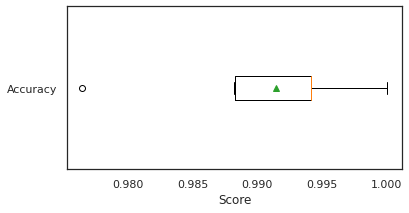


Accuracy media: 0.991 (0.005)



In [5]:
############################################################################################
# Cross validation de hipótesis 1:
############################################################################################

# Ubiquemos las columnas de la hipotesis:
columnas_cumple = [x[2] for x in tuplas_calidad]

# Transformaremos estas mediante un one-hot-encoder:
ct_cumple = ColumnTransformer(transformers=[
    ( 'onehot', OneHotEncoder(handle_unknown='ignore'), columnas_cumple),
])
# Usaremos un árbol de decisión
mo_cumple = DecisionTreeClassifier()

# Y las etiquetas las modificaremos con LabelEncoder()
le_cumple = LabelEncoder()
le_cumple.fit(y_train)

# Pipeline:
pipeline_cumple = Pipeline([
    ('ct', ct_cumple),
    ('mo', mo_cumple)
])

# Hagamos una validación cruzada para concoer el grado de bondad de este modelo:
kfold_cumple = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
resultados_cumple = cross_validate(pipeline_cumple, X_train, y_train, scoring='accuracy', cv=kfold_cumple)

# Grafiquemos los resultados de accuracy:
print(f"""
┌────────────────────────────────────────────────────┐
│Cross Validation:                                   │
│ > Contaminantes explican al semáforo               │
└────────────────────────────────────────────────────┘
""")
fig, ax = plt.subplots(figsize=(6,3))
plt.boxplot(resultados_cumple['test_score'], labels=['Accuracy'], vert=False, showmeans=True)
plt.xlabel('Score')
plt.show()

print(f"""
Accuracy media: { np.mean(resultados_cumple['test_score']):.3f} ({np.std(resultados_cumple['test_score']):.3f})
""")

En este experimento cruzado vemos excelentes valores. Validemos contra los datos de prueba:


┌────────────────────────────────────────────────────────┐
│Datos de prueba:                                        │
│ > Contaminantes explican al semáforo                   |
└────────────────────────────────────────────────────────┘



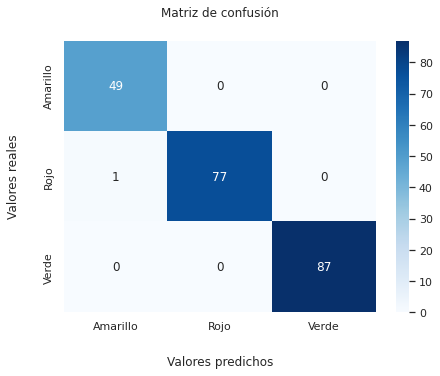



              precision    recall  f1-score   support

    Amarillo       0.98      1.00      0.99        49
        Rojo       1.00      0.99      0.99        78
       Verde       1.00      1.00      1.00        87

    accuracy                           1.00       214
   macro avg       0.99      1.00      0.99       214
weighted avg       1.00      1.00      1.00       214



In [6]:
############################################################################################
# Probando hipótesis 1 - árbol de decisión:
############################################################################################

# Declaramos un modelo:
mo_cumple = DecisionTreeClassifier(random_state=42)
ct_cumple.fit(X_train)
le_cumple.fit(y_train)

# Entrenamos el modelo:
mo_cumple.fit(
    ct_cumple.transform(X_train), 
    le_cumple.transform(y_train)
)

# Encontramos y verdadera y predicha:
y_true = le_cumple.transform(y_test)
y_pred = mo_cumple.predict(ct_cumple.transform(X_test))
y_classes = le_cumple.classes_

# Obetenemos la matriz de confusión y el reporte de accuracy
cmdf_cumple = pd.DataFrame(confusion_matrix(y_true, y_pred), index = y_classes, columns = y_classes)
#features = ct.transformers_[0][1].get_feature_names_out(columnas_cumple)
print(f"""
┌────────────────────────────────────────────────────────┐
│Datos de prueba:                                        │
│ > Contaminantes explican al semáforo                   |
└────────────────────────────────────────────────────────┘
""")

plt.figure(figsize=(7,5))
sns.heatmap(cmdf_cumple, annot=True, cmap='Blues', annot_kws={"size":12})
plt.title('Matriz de confusión', pad=24)
plt.ylabel('Valores reales', labelpad=24)
plt.xlabel('Valores predichos', labelpad=24)
plt.show()
print('\n')
print(classification_report(y_true, y_pred, target_names=y_classes))

El reporte anterior confirma que **podemos encontrar el color del semáforo bsandonos en si tienen o no contaminantes**. Como fue planteado en la sección uno, es fácil; distinguir cuando es verde (sin contaminantes) y sólo existe un pequeño ruido para Amarillo y Rojo pero en genera el modelo es bastante robusto con un F1-Score de 99%.

## Hipótesis 2 - El cumplimiento se determina por la calificación de calidad

Nuestra segunda hipótesis dice que los niveles de calidad es lo que determina si se cumple o no. Para comprobar esto repetiremos el experimento, esta vez con los valores de calidad como predictores de si cumplen o no.

In [7]:
############################################################################################
# Probando hipótesis 2 - árbol de decisión:
############################################################################################

for contaminante in tuplas_calidad:

  # Formemos X y y
  Xcol = contaminante[1]
  ycol = contaminante[2]

  # Transformaremos estas mediante un one-hot-encoder:
  ct_calidad = ColumnTransformer(remainder='drop', transformers=[
      ( 'onehot', OneHotEncoder(handle_unknown='ignore'), [Xcol])      
  ])

  # Usaremos un árbol de decisión:
  mo_calidad = DecisionTreeClassifier(random_state=42)
  
  # Y las etiquetas las modificaremos con LabelEncoder():
  le_calidad = LabelEncoder()
  le_calidad.fit(X_train[ycol])

  ct_calidad.fit(X_train)
  le_calidad.fit(X_train[ycol])

  # Entrenamos el modelo:
  mo_calidad.fit(
    ct_calidad.transform(X_train), 
    le_calidad.transform(X_train[ycol])
  )

  # Encontramos y verdadera y predicha:
  y_true = le_calidad.transform(X_test[ycol])
  y_pred = mo_calidad.predict(ct_calidad.transform(X_test))
  y_classes = le_calidad.classes_
  
  print(f'Accuracy: {accuracy_score(y_true, y_pred):.3f} con {np.sum(y_true!=y_pred)} errores, para [ {Xcol} ] ===> [ {ycol} ] ')

Accuracy: 1.000 con 0 errores, para [ CALIDAD_ALC ] ===> [ CUMPLE_CON_ALC ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_CONDUC ] ===> [ CUMPLE_CON_COND ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_SDT_ra ] ===> [ CUMPLE_CON_SDT_ra ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_SDT_salin ] ===> [ CUMPLE_CON_SDT_salin ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_FLUO ] ===> [ CUMPLE_CON_FLUO ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_DUR ] ===> [ CUMPLE_CON_DUR ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_COLI_FEC ] ===> [ CUMPLE_CON_CF ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_N_NO3 ] ===> [ CUMPLE_CON_NO3 ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_AS ] ===> [ CUMPLE_CON_AS ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_CD ] ===> [ CUMPLE_CON_CD ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_CR ] ===> [ CUMPLE_CON_CR ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_HG ] ===> [ CUMPLE_CON_HG ] 
Accuracy: 1.000 con 0 errores, para [ CALIDAD_PB ] ===

Observamos que efectivamente los valores de cumple se basan en los diferentes niveles de calidad. No parece una gran sorpresa ya que vimos limites numéricos muy bien definidos en el análisis exploratorio.

## Hipótesis 3 - El cumplimiento se determina se puede determinar por los valores numéricos

Ahora validemos si es posible determinar el nivel de cumplimiento con un árbol de decisión basado en los niveles de contaminación.

In [8]:
############################################################################################
# Probando hipótesis 3 - árbol de decisión:
############################################################################################

for contaminante in tuplas_calidad:

  # Formemos X y y
  Xcol = contaminante[0]
  ycol = contaminante[1]
  
  # Usaremos un pipeline basado en la estrategia planteada en la primer entrega:
  proprocess = Pipeline(steps = [
      ('ns', NumericStrategy()),
      ('inputer', SimpleImputer(strategy='median') )
  ])

  # Transformaremos cada columna objetivo con nuestro pipeline:
  ct_calidad = ColumnTransformer(remainder='drop', transformers=[
      ( 'preprocess', proprocess, [Xcol])
  ])

  # Usaremos un árbol de decisión:
  mo_calidad = DecisionTreeClassifier(random_state=42)
  
  # Y las etiquetas las modificaremos con LabelEncoder():
  le_calidad = LabelEncoder()
  le_calidad.fit(X_train[ycol])

  ct_calidad.fit(X_train)
  le_calidad.fit(X_train[ycol])

  # Entrenamos el modelo:
  mo_calidad.fit(
    ct_calidad.transform(X_train), 
    le_calidad.transform(X_train[ycol])
  )

  # Encontramos y verdadera y predicha:
  y_true = le_calidad.transform(X_test[ycol])
  y_pred = mo_calidad.predict(ct_calidad.transform(X_test))
  y_classes = le_calidad.classes_
  
  print(f'Accuracy: {accuracy_score(y_true, y_pred):.3f} con {np.sum(y_true!=y_pred)} errores para [ {Xcol} ] ===> [ {ycol} ] ')

Accuracy: 0.991 con 2 errores para [ ALC_mg/L ] ===> [ CALIDAD_ALC ] 
Accuracy: 1.000 con 0 errores para [ CONDUCT_mS/cm ] ===> [ CALIDAD_CONDUC ] 
Accuracy: 1.000 con 0 errores para [ SDT_M_mg/L ] ===> [ CALIDAD_SDT_ra ] 
Accuracy: 1.000 con 0 errores para [ SDT_M_mg/L ] ===> [ CALIDAD_SDT_salin ] 
Accuracy: 0.986 con 3 errores para [ FLUORUROS_mg/L ] ===> [ CALIDAD_FLUO ] 
Accuracy: 1.000 con 0 errores para [ DUR_mg/L ] ===> [ CALIDAD_DUR ] 
Accuracy: 1.000 con 0 errores para [ COLI_FEC_NMP/100_mL ] ===> [ CALIDAD_COLI_FEC ] 
Accuracy: 1.000 con 0 errores para [ N_NO3_mg/L ] ===> [ CALIDAD_N_NO3 ] 
Accuracy: 1.000 con 0 errores para [ AS_TOT_mg/L ] ===> [ CALIDAD_AS ] 
Accuracy: 1.000 con 0 errores para [ CD_TOT_mg/L ] ===> [ CALIDAD_CD ] 
Accuracy: 1.000 con 0 errores para [ CR_TOT_mg/L ] ===> [ CALIDAD_CR ] 
Accuracy: 1.000 con 0 errores para [ HG_TOT_mg/L ] ===> [ CALIDAD_HG ] 
Accuracy: 1.000 con 0 errores para [ PB_TOT_mg/L ] ===> [ CALIDAD_PB ] 
Accuracy: 1.000 con 0 errores pa

Los resultados son bastante buenos, exise una muy pequeña área de oportunidad en algunos contaminantes; hagamos el mismo experimento esta vez con árboles de decisión.

In [9]:
############################################################################################
# Probando hipótesis 3 - Bosque aleatorio:
############################################################################################

for contaminante in tuplas_calidad:

  # Formemos X y y
  Xcol = contaminante[0]
  ycol = contaminante[1]
  
  # Usaremos un pipeline basado en la estrategia planteada en la primer entrega:
  proprocess = Pipeline(steps = [
      ('ns', NumericStrategy()),
      ('inputer', SimpleImputer(strategy='median') )
  ])

  # Transformaremos cada columna objetivo con nuestro pipeline:
  ct_calidad = ColumnTransformer(remainder='drop', transformers=[
      ( 'preprocess', proprocess, [Xcol])
  ])

  # Usaremos un árbol de decisión:
  mo_calidad = RandomForestClassifier()
  
  # Y las etiquetas las modificaremos con LabelEncoder():
  le_calidad = LabelEncoder()
  le_calidad.fit(X_train[ycol])

  ct_calidad.fit(X_train)
  le_calidad.fit(X_train[ycol])

  # Entrenamos el modelo:
  mo_calidad.fit(
    ct_calidad.transform(X_train), 
    le_calidad.transform(X_train[ycol])
  )

  # Encontramos y verdadera y predicha:
  y_true = le_calidad.transform(X_test[ycol])
  y_pred = mo_calidad.predict(ct_calidad.transform(X_test))
  y_classes = le_calidad.classes_
  
  print(f'Accuracy: {accuracy_score(y_true, y_pred):.3f} con {np.sum(y_true!=y_pred)} errores para [ {Xcol} ] ===> [ {ycol} ] ')

Accuracy: 0.991 con 2 errores para [ ALC_mg/L ] ===> [ CALIDAD_ALC ] 
Accuracy: 1.000 con 0 errores para [ CONDUCT_mS/cm ] ===> [ CALIDAD_CONDUC ] 
Accuracy: 1.000 con 0 errores para [ SDT_M_mg/L ] ===> [ CALIDAD_SDT_ra ] 
Accuracy: 1.000 con 0 errores para [ SDT_M_mg/L ] ===> [ CALIDAD_SDT_salin ] 
Accuracy: 0.986 con 3 errores para [ FLUORUROS_mg/L ] ===> [ CALIDAD_FLUO ] 
Accuracy: 1.000 con 0 errores para [ DUR_mg/L ] ===> [ CALIDAD_DUR ] 
Accuracy: 1.000 con 0 errores para [ COLI_FEC_NMP/100_mL ] ===> [ CALIDAD_COLI_FEC ] 
Accuracy: 1.000 con 0 errores para [ N_NO3_mg/L ] ===> [ CALIDAD_N_NO3 ] 
Accuracy: 1.000 con 0 errores para [ AS_TOT_mg/L ] ===> [ CALIDAD_AS ] 
Accuracy: 1.000 con 0 errores para [ CD_TOT_mg/L ] ===> [ CALIDAD_CD ] 
Accuracy: 1.000 con 0 errores para [ CR_TOT_mg/L ] ===> [ CALIDAD_CR ] 
Accuracy: 1.000 con 0 errores para [ HG_TOT_mg/L ] ===> [ CALIDAD_HG ] 
Accuracy: 1.000 con 0 errores para [ PB_TOT_mg/L ] ===> [ CALIDAD_PB ] 
Accuracy: 1.000 con 0 errores pa

No encontramos ninguna mejora con este método; era algo difícil ya que al parecer lo que no encontramos tiene que ver con un ruido de falta de medición.

## Nueva hipótesis - Transitividad de predicción:

Considerando que nnuestros 3 modelos han probado bastante efectividad, es probble que podamos omitar el paso entre calidad y cumple al hacer el nivel de medición responsable directo de ver si cumple o no. Para esto utilizaremos un bosque aleatorio entre medición y cumple

In [10]:
############################################################################################
# Probando nueva hipótesis:
############################################################################################

for contaminante in tuplas_calidad:

  # Formemos X y y
  Xcol = contaminante[0]
  ycol = contaminante[2]
  
  # Usaremos un pipeline basado en la estrategia planteada en la primer entrega:
  proprocess = Pipeline(steps = [
      ('ns', NumericStrategy()),
      ('inputer', SimpleImputer(strategy='median') )
  ])

  # Transformaremos cada columna objetivo con nuestro pipeline:
  ct_calidad = ColumnTransformer(remainder='drop', transformers=[
      ( 'preprocess', proprocess, [Xcol])
  ])

  # Usaremos un árbol de decisión:
  mo_calidad = RandomForestClassifier()
  
  # Y las etiquetas las modificaremos con LabelEncoder():
  le_calidad = LabelEncoder()
  le_calidad.fit(X_train[ycol])

  ct_calidad.fit(X_train)
  le_calidad.fit(X_train[ycol])

  # Entrenamos el modelo:
  mo_calidad.fit(
    ct_calidad.transform(X_train), 
    le_calidad.transform(X_train[ycol])
  )

  # Encontramos y verdadera y predicha:
  y_true = le_calidad.transform(X_test[ycol])
  y_pred = mo_calidad.predict(ct_calidad.transform(X_test))
  y_classes = le_calidad.classes_
  
  print(f'Accuracy: {accuracy_score(y_true, y_pred):.3f} con {np.sum(y_true!=y_pred)} errores para [ {Xcol} ] ===> [ {ycol} ] ')

Accuracy: 1.000 con 0 errores para [ ALC_mg/L ] ===> [ CUMPLE_CON_ALC ] 
Accuracy: 1.000 con 0 errores para [ CONDUCT_mS/cm ] ===> [ CUMPLE_CON_COND ] 
Accuracy: 1.000 con 0 errores para [ SDT_M_mg/L ] ===> [ CUMPLE_CON_SDT_ra ] 
Accuracy: 1.000 con 0 errores para [ SDT_M_mg/L ] ===> [ CUMPLE_CON_SDT_salin ] 
Accuracy: 0.991 con 2 errores para [ FLUORUROS_mg/L ] ===> [ CUMPLE_CON_FLUO ] 
Accuracy: 1.000 con 0 errores para [ DUR_mg/L ] ===> [ CUMPLE_CON_DUR ] 
Accuracy: 1.000 con 0 errores para [ COLI_FEC_NMP/100_mL ] ===> [ CUMPLE_CON_CF ] 
Accuracy: 1.000 con 0 errores para [ N_NO3_mg/L ] ===> [ CUMPLE_CON_NO3 ] 
Accuracy: 1.000 con 0 errores para [ AS_TOT_mg/L ] ===> [ CUMPLE_CON_AS ] 
Accuracy: 1.000 con 0 errores para [ CD_TOT_mg/L ] ===> [ CUMPLE_CON_CD ] 
Accuracy: 1.000 con 0 errores para [ CR_TOT_mg/L ] ===> [ CUMPLE_CON_CR ] 
Accuracy: 1.000 con 0 errores para [ HG_TOT_mg/L ] ===> [ CUMPLE_CON_HG ] 
Accuracy: 1.000 con 0 errores para [ PB_TOT_mg/L ] ===> [ CUMPLE_CON_PB ] 
Acc

¡Maravilloso! Vemos que el nivel de cumple o no se peude determinar por los valores numéricos (basados en nuestra estrátegia de input y mediana); este pequeño modelo produjo apenas 3 errores mientras que el modelo final produjo sólo 1 por lo que esperamos tener un modelo bastante robusto al final.

# Modelo Final

Habiendo concluido parcialmente que:

``` markdown
{medición}---(predice)--->{calidad}---(predice)--->{cumple}--->(predice)--->{semáforo}
````
Podemos asumir que:

``` markdown
{medición}---(predice)--->{cumple}--->(predice)--->{semáforo}
````
Por lo que en general sólo necesitamos dos modelos:

``` markdown
Modelo_0i:  {medición_i}--->{cumple_i}
Modelo_1:   {cumple}--->{semáforo}
```
Para ambos modelos usaremos RandomForestClassifiers, el Modelo_1 es una generalización por one-hot-encoding que recibe los datos de si cumple o no y arroja un semáforo; los $modelos0_i$ sonmodelos que predicen si cumple o no basado en la medición.



## Modelo 0: CUMPLE - SEMÁFORO
Este modelo es una generalización de la hipótesis 1.

Creemos primero un encoder para los colores de semáforo

In [11]:
# Encoder de y
le = LabelEncoder()
le.fit(y_train)
y_classes = le.classes_

Ahora creemos nuestro modelo que dado un conjunto CUMPLE devuelve el color del semáforo. Este módelo usa one-hot encoder sobre las variables que observa.

In [12]:
############################################################################################
# Creación de Modelo 0
############################################################################################

# One-Hot Encoder para variables de cumplimiento:
ct = ColumnTransformer(remainder='drop', transformers=[
    ( 'onehot', OneHotEncoder(handle_unknown='ignore'), [t[2] for t in tuplas_calidad])
])
ct.fit(X_train[[t[2] for t in tuplas_calidad]])

# Random forest:
model = RandomForestClassifier()

# Entrenamos el modelo:
model.fit(
    ct.transform(X_train[[t[2] for t in tuplas_calidad]]), 
    le.transform(y_train)
)

model

RandomForestClassifier()


┌────────────────────────────────────────────────────────┐
│Datos de prueba:                                        │
│ > Contaminantes explican al semáforo                   |
└────────────────────────────────────────────────────────┘



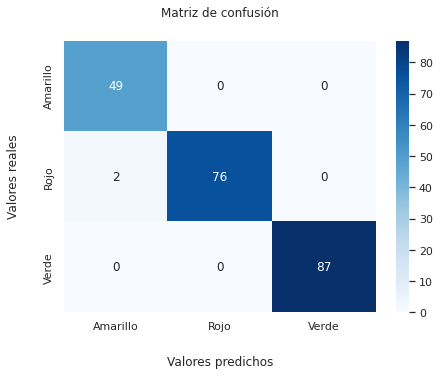



              precision    recall  f1-score   support

    Amarillo       0.96      1.00      0.98        49
        Rojo       1.00      0.97      0.99        78
       Verde       1.00      1.00      1.00        87

    accuracy                           0.99       214
   macro avg       0.99      0.99      0.99       214
weighted avg       0.99      0.99      0.99       214



In [13]:
############################################################################################
# Evaluación de Modelo 0
############################################################################################

# Encontramos y verdadera y predicha:
y_true = le.transform(y_test)
y_pred = model.predict(ct.transform(X_test))

# Obetenemos la matriz de confusión y el reporte de accuracy
cmdf_mo1 = pd.DataFrame(confusion_matrix(y_true, y_pred), index = y_classes, columns = y_classes)

print(f"""
┌────────────────────────────────────────────────────────┐
│Datos de prueba:                                        │
│ > Contaminantes explican al semáforo                   |
└────────────────────────────────────────────────────────┘
""")

plt.figure(figsize=(7,5))
sns.heatmap(cmdf_mo1, annot=True, cmap='Blues', annot_kws={"size":12})
plt.title('Matriz de confusión', pad=24)
plt.ylabel('Valores reales', labelpad=24)
plt.xlabel('Valores predichos', labelpad=24)
plt.show()
print('\n')
print(classification_report(y_true, y_pred, target_names=y_classes))

Los resultados esperados y vistos en nuestra hipótesis 1. Por su puesto el reto es entonces: Cómo obtenemos modelos que determinen si un contaminante cumple o no.

## Modelo $1_i$: CONTAMINANTE - CUMPLE

Estos modelos son una expansión de la hipótesis 3. Sin embargo uno de los elementos del modelo era como lidiaba con los datos numéricos no capturados en donde utilizamos una mediana; sin embargo quisieramos expandir esto en base a lo encontrado en el análisis I entregado en la primera part de este reto; ahí descubrimos que la locación podría ser un factor y por lo tanto queremos hacer un mejor input que considere esto.

### Imput por KNN (basado en las observaciones de K-Means)


Basado en los K-Means vimos homogeneidad de colores dentro de ellos, por lo que expandiremos eso usando la LONG y LAT para determinar vecinos cercanos con KNN, que es otro algoritmo con similitud a K-Means. La hipótesis es sencilla: lugares cercanos tienen valores cercanos en contaminantes; si esto es cierto, entonces podemos hacer el input cuando no lo tengamos como el promedio de los más cercanos.

Esta aplciación es sencilla: Formaremos mini modelos (i) por contaminante que tomarán su longitud, latitud y nivel de contaminación; nuestro modelo entrenará con esta información y hará un método de imput, tal que tome el promedio de los puntos más cercanos.

Ponemos a continuación un ejemplo gráfico de como funcionaria esto:

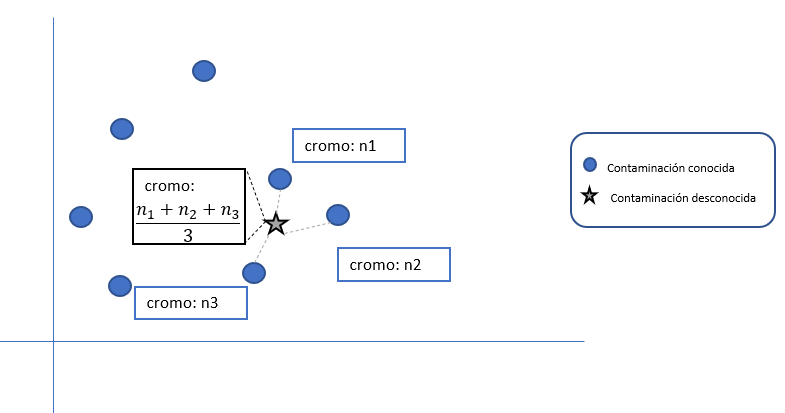

In [14]:
############################################################################################
# Modelos i de input: LONG + LAT + {i_desconocida} = KNN de LONG + LAT + {i_conocida}
############################################################################################

# Función interna para hacer input para casteo numérico y KNN:
def mo_InputKNNContaminanteLongLat(column):
  # Pipeline de datos:
  proprocess = Pipeline(steps = [
      ('ns', NumericStrategy()),
      ('inputer', KNNImputer(n_neighbors=3)),
  ])

  # Transformación:
  ct = ColumnTransformer(remainder='drop', transformers=[
      ( 'preprocess', proprocess, [column]+['LONGITUD', 'LATITUD']),
  ])

  # Aplicar al conjunto de entenamiento y regresar el modelo listo para transformar:
  ct.fit(X_train[[column]+['LONGITUD', 'LATITUD']])
  return ct

# Creemos los inputers basados en KNN:
InputALC       = mo_InputKNNContaminanteLongLat('ALC_mg/L')
InputCONDUCT   = mo_InputKNNContaminanteLongLat('CONDUCT_mS/cm')
InputSDT       = mo_InputKNNContaminanteLongLat('SDT_M_mg/L')
InputFLUORUROS = mo_InputKNNContaminanteLongLat('FLUORUROS_mg/L')
InputDUR       = mo_InputKNNContaminanteLongLat('DUR_mg/L')
InputCF        = mo_InputKNNContaminanteLongLat('COLI_FEC_NMP/100_mL')
InputNNO3      = mo_InputKNNContaminanteLongLat('N_NO3_mg/L')
InputAS        = mo_InputKNNContaminanteLongLat('AS_TOT_mg/L')
InputCD        = mo_InputKNNContaminanteLongLat('CD_TOT_mg/L')
InputCR        = mo_InputKNNContaminanteLongLat('CR_TOT_mg/L')
InputHG        = mo_InputKNNContaminanteLongLat('HG_TOT_mg/L')
InputPB        = mo_InputKNNContaminanteLongLat('PB_TOT_mg/L')
InputMN        = mo_InputKNNContaminanteLongLat('MN_TOT_mg/L')
InputFE        = mo_InputKNNContaminanteLongLat('FE_TOT_mg/L')

# Regresmo además una forma de convertir un conjunto de datos de contaminantes en este output con input:
def get_Contaminantes(user_df):
  d = dict({ 
    'LONGITUD': user_df['LONGITUD'],
    'LATITUD': user_df['LATITUD'],
    'ALC_mg/L': InputALC.transform(user_df)[:,0],
    'CONDUCT_mS/cm': InputCONDUCT.transform(user_df)[:,0],
    'SDT_M_mg/L': InputSDT.transform(user_df)[:,0],
    'FLUORUROS_mg/L': InputFLUORUROS.transform(user_df)[:,0],
    'DUR_mg/L': InputDUR.transform(user_df)[:,0],
    'COLI_FEC_NMP/100_mL': InputCF.transform(user_df)[:,0],
    'N_NO3_mg/L': InputNNO3.transform(user_df)[:,0],
    'AS_TOT_mg/L': InputAS.transform(user_df)[:,0],
    'CD_TOT_mg/L': InputCD.transform(user_df)[:,0],
    'CR_TOT_mg/L': InputCR.transform(user_df)[:,0],
    'HG_TOT_mg/L': InputHG.transform(user_df)[:,0],
    'PB_TOT_mg/L': InputPB.transform(user_df)[:,0],
    'MN_TOT_mg/L': InputMN.transform(user_df)[:,0],
    'FE_TOT_mg/L': InputFE.transform(user_df)[:,0],
  })
  return pd.DataFrame(d, columns=['LONGITUD', 'LATITUD'] + list(set([t[0] for t in tuplas_calidad])))

In [15]:
# Lista de contaminantes
col_contaminantes = ['LONGITUD', 'LATITUD'] + list(set([t[0] for t in tuplas_calidad]))
# Contaminantes sin transformación:
X_train[col_contaminantes].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 854 entries, 905 to 942
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LONGITUD             854 non-null    float64
 1   LATITUD              854 non-null    float64
 2   FLUORUROS_mg/L       854 non-null    object 
 3   N_NO3_mg/L           853 non-null    object 
 4   CD_TOT_mg/L          854 non-null    object 
 5   HG_TOT_mg/L          854 non-null    object 
 6   AS_TOT_mg/L          854 non-null    object 
 7   CONDUCT_mS/cm        849 non-null    float64
 8   ALC_mg/L             852 non-null    float64
 9   CR_TOT_mg/L          854 non-null    object 
 10  FE_TOT_mg/L          854 non-null    object 
 11  PB_TOT_mg/L          854 non-null    object 
 12  SDT_M_mg/L           852 non-null    object 
 13  COLI_FEC_NMP/100_mL  854 non-null    object 
 14  MN_TOT_mg/L          854 non-null    object 
 15  DUR_mg/L             853 non-null    o

In [16]:
# Contaminantes transofrmados:
get_Contaminantes(X_test).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 139 to 449
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LONGITUD             214 non-null    float64
 1   LATITUD              214 non-null    float64
 2   FLUORUROS_mg/L       214 non-null    float64
 3   N_NO3_mg/L           214 non-null    float64
 4   CD_TOT_mg/L          214 non-null    float64
 5   HG_TOT_mg/L          214 non-null    float64
 6   AS_TOT_mg/L          214 non-null    float64
 7   CONDUCT_mS/cm        214 non-null    float64
 8   ALC_mg/L             214 non-null    float64
 9   CR_TOT_mg/L          214 non-null    float64
 10  FE_TOT_mg/L          214 non-null    float64
 11  PB_TOT_mg/L          214 non-null    float64
 12  SDT_M_mg/L           214 non-null    float64
 13  COLI_FEC_NMP/100_mL  214 non-null    float64
 14  MN_TOT_mg/L          214 non-null    float64
 15  DUR_mg/L             214 non-null    f

### Modelos de mediciones a cumple

Utilizando nuestro input crearemos un módelo que regrese si las variables cumplen o no

In [17]:
############################################################################################
# Modelos i de input: LONG + LAT + {i_desconocida} = KNN de LONG + LAT + {i_conocida}
############################################################################################

def mo_Cumple(contaminante, cumple):
    # Formemos X y y
    Xtr = get_Contaminantes(X_train)[[contaminante]]
    ytr = X_train[cumple]

    # Y las etiquetas las modificaremos con LabelEncoder():
    le = LabelEncoder()
    le.fit(ytr)

    # Random forest:
    mo = RandomForestClassifier()

    # Entrenamos el modelo:
    mo.fit( Xtr, le.transform(ytr))
    # Entrenamos el modelo:
    return mo, le.classes_

# Creemos los módelos y etiquetas:
mo_ALC       , lbl_ALC       = mo_Cumple('ALC_mg/L', 'CUMPLE_CON_ALC')
mo_CONDUCT   , lbl_CONDUCT   = mo_Cumple('CONDUCT_mS/cm', 'CUMPLE_CON_COND')
mo_SDT_ra    , lbl_SDT_ra    = mo_Cumple('SDT_M_mg/L', 'CUMPLE_CON_SDT_ra')
mo_SDT_salin , lbl_SDT_salin = mo_Cumple('SDT_M_mg/L', 'CUMPLE_CON_SDT_salin')
mo_FLUORUROS , lbl_FLUORUROS = mo_Cumple('FLUORUROS_mg/L', 'CUMPLE_CON_FLUO')
mo_DUR       , lbl_DUR       = mo_Cumple('DUR_mg/L', 'CUMPLE_CON_DUR')
mo_CF        , lbl_CF        = mo_Cumple('COLI_FEC_NMP/100_mL', 'CUMPLE_CON_CF')
mo_NNO3      , lbl_NNO3      = mo_Cumple('N_NO3_mg/L', 'CUMPLE_CON_NO3')
mo_AS        , lbl_AS        = mo_Cumple('AS_TOT_mg/L', 'CUMPLE_CON_AS')
mo_CD        , lbl_CD        = mo_Cumple('CD_TOT_mg/L', 'CUMPLE_CON_CD')
mo_CR        , lbl_CR        = mo_Cumple('CR_TOT_mg/L', 'CUMPLE_CON_CR')
mo_HG        , lbl_HG        = mo_Cumple('HG_TOT_mg/L', 'CUMPLE_CON_HG')
mo_PB        , lbl_PB        = mo_Cumple('PB_TOT_mg/L', 'CUMPLE_CON_PB')
mo_MN        , lbl_MN        = mo_Cumple('MN_TOT_mg/L', 'CUMPLE_CON_MN')
mo_FE        , lbl_FE        = mo_Cumple('FE_TOT_mg/L', 'CUMPLE_CON_FE')



In [18]:
def get_Cumple(user_df):
  d = dict({ 
    'CUMPLE_CON_ALC': [lbl_ALC[v] for v in mo_ALC.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'ALC_mg/L']])[['ALC_mg/L']])],
    'CUMPLE_CON_COND': [lbl_CONDUCT[v] for v in mo_CONDUCT.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'CONDUCT_mS/cm']])[['CONDUCT_mS/cm']])],
    'CUMPLE_CON_SDT_ra': [lbl_SDT_ra[v] for v in mo_SDT_ra.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'SDT_M_mg/L']])[['SDT_M_mg/L']])],
    'CUMPLE_CON_SDT_salin': [lbl_SDT_salin[v] for v in mo_SDT_salin.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'SDT_M_mg/L']])[['SDT_M_mg/L']])],
    'CUMPLE_CON_FLUO': [lbl_FLUORUROS[v] for v in mo_FLUORUROS.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'FLUORUROS_mg/L']])[['FLUORUROS_mg/L']])],
    'CUMPLE_CON_DUR': [lbl_DUR[v] for v in mo_DUR.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'DUR_mg/L']])[['DUR_mg/L']])],
    'CUMPLE_CON_CF': [lbl_CF[v] for v in mo_CF.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'COLI_FEC_NMP/100_mL']])[['COLI_FEC_NMP/100_mL']])],
    'CUMPLE_CON_NO3': [lbl_NNO3[v] for v in mo_NNO3.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'N_NO3_mg/L']])[['N_NO3_mg/L']])],
    'CUMPLE_CON_AS': [lbl_AS[v] for v in mo_AS.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'AS_TOT_mg/L']])[['AS_TOT_mg/L']])],
    'CUMPLE_CON_CD': [lbl_CD[v] for v in mo_CD.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'CD_TOT_mg/L']])[['CD_TOT_mg/L']])],
    'CUMPLE_CON_CR': [lbl_CR[v] for v in mo_CR.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'CR_TOT_mg/L']])[['CR_TOT_mg/L']])],
    'CUMPLE_CON_HG': [lbl_HG[v] for v in mo_HG.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'HG_TOT_mg/L']])[['HG_TOT_mg/L']])],
    'CUMPLE_CON_PB': [lbl_PB[v] for v in mo_PB.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'PB_TOT_mg/L']])[['PB_TOT_mg/L']])],
    'CUMPLE_CON_MN': [lbl_MN[v] for v in mo_MN.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'MN_TOT_mg/L']])[['MN_TOT_mg/L']])],
    'CUMPLE_CON_FE': [lbl_FE[v] for v in mo_FE.predict((get_Contaminantes(user_df)[['LONGITUD', 'LATITUD', 'FE_TOT_mg/L']])[['FE_TOT_mg/L']])]
  })
  return pd.DataFrame(d)

In [19]:
get_Cumple(X_train)

,CUMPLE_CON_ALC,CUMPLE_CON_COND,CUMPLE_CON_SDT_ra,CUMPLE_CON_SDT_salin,CUMPLE_CON_FLUO,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,SI,SI,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,SI,SI,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI,SI,NO
2,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
3,SI,NO,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,SI,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
850,SI,NO,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
851,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,NO,SI
852,SI,SI,SI,SI,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


### Modelo

Nuestro Modelo está entonces basado en 14 inputers de KNN para los valores numéricos; 14 árboles de decisión para determinar si cumplen o no y 1 para validar el semáforo.

# Resultados


┌────────────────────────────────────────────────────────┐
│Datos de prueba:                                        │
│ > Contaminantes explican al semáforo                   |
└────────────────────────────────────────────────────────┘



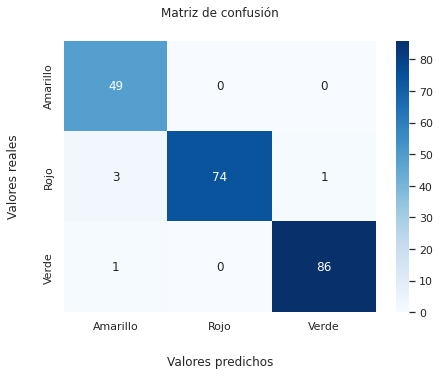



              precision    recall  f1-score   support

    Amarillo       0.92      1.00      0.96        49
        Rojo       1.00      0.95      0.97        78
       Verde       0.99      0.99      0.99        87

    accuracy                           0.98       214
   macro avg       0.97      0.98      0.97       214
weighted avg       0.98      0.98      0.98       214



In [20]:
############################################################################################
# Evaluación de Modelo 0
############################################################################################

# Encontramos y verdadera y predicha:
y_true = le.transform(y_test)
y_pred = model.predict(ct.transform(get_Cumple(X_test)))

# Obetenemos la matriz de confusión y el reporte de accuracy
cmdf_mo1 = pd.DataFrame(confusion_matrix(y_true, y_pred), index = y_classes, columns = y_classes)

print(f"""
┌────────────────────────────────────────────────────────┐
│Datos de prueba:                                        │
│ > Contaminantes explican al semáforo                   |
└────────────────────────────────────────────────────────┘
""")

plt.figure(figsize=(7,5))
sns.heatmap(cmdf_mo1, annot=True, cmap='Blues', annot_kws={"size":12})
plt.title('Matriz de confusión', pad=24)
plt.ylabel('Valores reales', labelpad=24)
plt.xlabel('Valores predichos', labelpad=24)
plt.show()
print('\n')
print(classification_report(y_true, y_pred, target_names=y_classes))

Veamos la importancia de nuestro modelo:

Este modelo aunque tuvo un performance un poco menor utiliza una mejor hipótesis de imput basado en cuerpos de agua cercanos en lugar de una simple mediana.

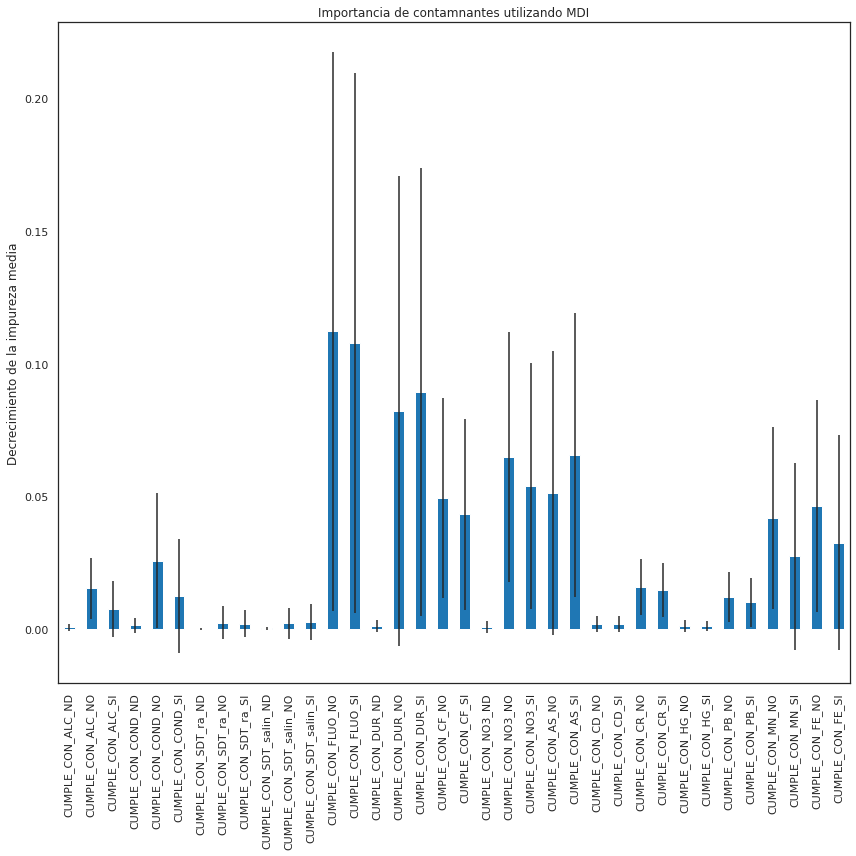

In [21]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = ct.named_transformers_['onehot'].get_feature_names_out(get_Cumple(X_train).columns).tolist()
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(12,12))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importancia de contamnantes utilizando MDI")
ax.set_ylabel("Decrecimiento de la impureza media")
fig.tight_layout()

Vemos como variables como el FLUOR, la DUREZA, Arsénico, NO3 tienen bastante importancia, meitnras que otras variables como el Cadmio (no encontrado), Mercurio (no encontrado) y la Conductividad no tienen que ver tanto con la decisión del modelo

Por último en esta sección, vimos como el modelo alcanzó un perfomance de 0.98 cuando valores están presentes; si embargo, este puede ser un supuesto bastante audaz, aveces no hay recursos para esto. Entonces ¿Qué hacer?

# Modelo de Producción

Finalmente gracias al análisis de K-Means y ampliación por KNN hemos creado un imputer que sólo depende de LONGITUD y LATITUD; utiliza, agradece y mejora su perfomance entre más valores tenga, pero si es posible predecir sólo por estas dos variables que serían las esenciales ante el descubrimiento de cuerpos de agua. Definiremos dos funciones para hacer métodos productivos de esto:


In [22]:
def get_semaforo_by_val(dictval, labeled=True):
  """
  Este modelo toma valores en un formato JSON o de diccionario
  en donde requiere LONGITUD y LATITUD, además acepta los siguientes
  valores de medición de contaminación:

    'LONGITUD,
    'LATITUD,
    'ALC_mg/L',
    'CONDUCT_mS/cm',
    'SDT_M_mg/L',
    'FLUORUROS_mg/L',
    'DUR_mg/L',
    'COLI_FEC_NMP/100_mL',
    'N_NO3_mg/L',
    'AS_TOT_mg/L',
    'CD_TOT_mg/L',
    'CR_TOT_mg/L',
    'HG_TOT_mg/L',
    'PB_TOT_mg/L',
    'MN_TOT_mg/L',
    'FE_TOT_mg/L',

  Al final el modelo regresa un semáforo basado en esas observaciones.
  """
  
  # Tomar los valores de usuario:
  user_long = dictval.get('LONGITUD')
  user_lat = dictval.get('LATITUD')
  user_alc = dictval.get('ALC_mg/L') or np.nan
  user_cond = dictval.get('CONDUCT_mS/cm') or np.nan
  user_sdt = dictval.get('SDT_M_mg/L') or np.nan
  user_fluo = dictval.get('FLUORUROS_mg/L') or np.nan
  user_dur = dictval.get('DUR_mg/L') or np.nan
  user_cf = dictval.get('COLI_FEC_NMP/100_mL') or np.nan
  user_nno3 = dictval.get('N_NO3_mg/L') or np.nan
  user_as = dictval.get('AS_TOT_mg/L') or np.nan
  user_cd = dictval.get('CD_TOT_mg/L') or np.nan
  user_cr = dictval.get('CR_TOT_mg/L') or np.nan
  user_hg = dictval.get('HG_TOT_mg/L') or np.nan
  user_pb = dictval.get('PB_TOT_mg/L') or np.nan
  user_mn = dictval.get('MN_TOT_mg/L') or np.nan
  user_fe = dictval.get('FE_TOT_mg/L') or np.nan


  # Early exit:
  if user_long is None or user_lat is None:
    raise "Este modelo requeire almenos LONGITUD Y LATITUD"

  input_ml = [
      user_long,
      user_lat,
      user_alc,
      user_cond,
      user_sdt,
      user_fluo,
      user_dur,
      user_cf,
      user_nno3,
      user_as,
      user_cd,
      user_cr,
      user_hg,
      user_pb,
      user_mn,
      user_fe,
  ]

  columns_input = [
    'LONGITUD',
    'LATITUD',
    'ALC_mg/L',
    'CONDUCT_mS/cm',
    'SDT_M_mg/L',    
    'FLUORUROS_mg/L',
    'DUR_mg/L',
    'COLI_FEC_NMP/100_mL',
    'N_NO3_mg/L',
    'AS_TOT_mg/L',
    'CD_TOT_mg/L',
    'CR_TOT_mg/L',
    'HG_TOT_mg/L',
    'PB_TOT_mg/L',
    'MN_TOT_mg/L',
    'FE_TOT_mg/L'
  ]
  
  # Convertirmos JSON a np array:
  input_list = np.reshape(input_ml, (1, 16)) 
  # Convertirmos np array a DF:
  input_df = pd.DataFrame(input_list, columns=columns_input)
  # Creamos los valores de cumple del df:
  input_vals = get_Cumple(input_df)
  # Transformamos a input correcto de modelo:
  input_ml = ct.transform(input_vals)
  # Predecimos basado en datos:
  output_ml = model.predict(input_ml)
  # Entregamos el semáforo:
  if labeled:
    return [ y_classes[v] for v in output_ml ]
  else:
    return output_ml


def get_semaforo_by_df(userdf, labeled=True):
  """
  Este modelo toma valores en un formato dataframe con forma:

    'LONGITUD', (non-null)
    'LATITUD', (non-null)
    'ALC_mg/L',
    'CONDUCT_mS/cm',
    'SDT_M_mg/L',
    'FLUORUROS_mg/L',
    'DUR_mg/L',
    'COLI_FEC_NMP/100_mL',
    'N_NO3_mg/L',
    'AS_TOT_mg/L',
    'CD_TOT_mg/L',
    'CR_TOT_mg/L',
    'HG_TOT_mg/L',
    'PB_TOT_mg/L',
    'MN_TOT_mg/L',
    'FE_TOT_mg/L',

  Al final el modelo regresa un semáforo basado en esas observaciones.
  """
    # Early exit:
  if userdf['LONGITUD'].isna().sum() > 0 or userdf['LATITUD'].isna().sum() > 0:
    raise "Este modelo requeire almenos LONGITUD Y LATITUD"
  
  # Creamos los valores de cumple del df:
  input_vals = get_Cumple(userdf)
  # Transformamos a input correcto de modelo:
  input_ml = ct.transform(input_vals)
  # Predecimos basado en datos:
  output_ml = model.predict(input_ml)
  # Etiquetamos el resultado:
  
  # Entregamos el semáforo:
  if labeled:
    return [ y_classes[v] for v in output_ml ]
  else:
    return output_ml


Nuestra primer función toma valores unitarios de longitud y latitud y además mediciones de calidad del agua para predecir su nivel. Veamos un ejemplo con sólo su ubicación:

In [23]:
# Test function:
get_semaforo_by_val({
    'LONGITUD': -102.17488,
    'LATITUD': 25.48890
    })

['Amarillo']

Ahora veamos que pasa si ponemos un nivel no aceptable de arsénico:

In [24]:
# Test function:
get_semaforo_by_val({
    'LONGITUD': -102.17488,
    'LATITUD': 25.48890,
    'AS_TOT_mg/L': 0.033,
    })

['Rojo']

Como se observa el modelo refina sus predicciones entre más valores tenga

In [25]:
# Test function:
get_semaforo_by_df(
    pd.DataFrame({ 
    'LONGITUD': [-102.17488],
    'LATITUD': [25.48890],
    'ALC_mg/L': [np.nan],
    'CONDUCT_mS/cm': [np.nan],
    'SDT_M_mg/L': [np.nan],
    'FLUORUROS_mg/L': [np.nan],
    'DUR_mg/L': [np.nan],
    'COLI_FEC_NMP/100_mL': [np.nan],
    'N_NO3_mg/L': [np.nan],
    'AS_TOT_mg/L': [np.nan],
    'CD_TOT_mg/L': [np.nan],
    'CR_TOT_mg/L': [np.nan],
    'HG_TOT_mg/L': [np.nan],
    'PB_TOT_mg/L': [np.nan],
    'MN_TOT_mg/L': [np.nan],
    'FE_TOT_mg/L': [np.nan],
  })
)

['Amarillo']

Nuestro segundo modelo toma valores de un dataframe con la estructura LAT,LONG y los contaminantes, los valores de contaminantes puedne o no tener valores y produce los mismos resultados.

In [26]:
# Test function:
get_semaforo_by_df(
    pd.DataFrame({ 
    'LONGITUD': [-102.17488],
    'LATITUD': [25.48890],
    'ALC_mg/L': [np.nan],
    'CONDUCT_mS/cm': [np.nan],
    'SDT_M_mg/L': [np.nan],
    'FLUORUROS_mg/L': [np.nan],
    'DUR_mg/L': [np.nan],
    'COLI_FEC_NMP/100_mL': [np.nan],
    'N_NO3_mg/L': [np.nan],
    'AS_TOT_mg/L': 0.033,
    'CD_TOT_mg/L': [np.nan],
    'CR_TOT_mg/L': [np.nan],
    'HG_TOT_mg/L': [np.nan],
    'PB_TOT_mg/L': [np.nan],
    'MN_TOT_mg/L': [np.nan],
    'FE_TOT_mg/L': [np.nan],
  })
)

['Rojo']

Aquí vemos como aumenta el nivel a rojo también al presentar niveles no aceptables de arsénico en el agua.

Lo anterior lo podemos generalizar para nuestro conjunto de prueba y ver que sucede cuando tenemos o no ciertas variables. Para esto hagamos un experimento en el que removeremos ciertas variablaes de forma aleatoria:

In [27]:
############################################################################################
# Aleatorizando presencia de variables:
############################################################################################

# Encontramos y verdadera y predicha:

ALC_isPresent = random.random() > 0.5
CONDUCT_isPresent = random.random() > 0.5
SDT_isPresent = random.random() > 0.5
SDT_isPresent = random.random() > 0.5
DUR_isPresent = random.random() > 0.5
CF_isPresent = random.random() > 0.5
NNO3_isPresent = random.random() > 0.5
AS_isPresent = random.random() > 0.5
CD_isPresent = random.random() > 0.5
CR_isPresent = random.random() > 0.5
HG_isPresent = random.random() > 0.5
PB_isPresent = random.random() > 0.5
MN_isPresent = random.random() > 0.5
FE_isPresent = random.random() > 0.5

y_true = le.transform(y_test)
y_pred = get_semaforo_by_df(
    pd.DataFrame({ 
    'LONGITUD': X_test['LONGITUD'],
    'LATITUD': X_test['LATITUD'],
    'ALC_mg/L': X_test['ALC_mg/L']  if ALC_isPresent else np.repeat(np.nan, 214),
    'CONDUCT_mS/cm': X_test['CONDUCT_mS/cm']  if CONDUCT_isPresent else np.repeat(np.nan, 214),
    'SDT_M_mg/L': X_test['SDT_M_mg/L']  if SDT_isPresent else np.repeat(np.nan, 214),
    'FLUORUROS_mg/L': X_test['FLUORUROS_mg/L']  if SDT_isPresent else np.repeat(np.nan, 214),
    'DUR_mg/L': X_test['DUR_mg/L']  if DUR_isPresent else np.repeat(np.nan, 214),
    'COLI_FEC_NMP/100_mL': X_test['COLI_FEC_NMP/100_mL']  if CF_isPresent else np.repeat(np.nan, 214),
    'N_NO3_mg/L': X_test['N_NO3_mg/L']  if NNO3_isPresent else np.repeat(np.nan, 214),
    'AS_TOT_mg/L': X_test['AS_TOT_mg/L']  if AS_isPresent else np.repeat(np.nan, 214),
    'CD_TOT_mg/L': X_test['CD_TOT_mg/L']  if CD_isPresent else np.repeat(np.nan, 214),
    'CR_TOT_mg/L': X_test['CR_TOT_mg/L']  if CR_isPresent else np.repeat(np.nan, 214),
    'HG_TOT_mg/L': X_test['HG_TOT_mg/L']  if HG_isPresent else np.repeat(np.nan, 214),
    'PB_TOT_mg/L': X_test['PB_TOT_mg/L']  if PB_isPresent else np.repeat(np.nan, 214),
    'MN_TOT_mg/L': X_test['MN_TOT_mg/L']  if MN_isPresent else np.repeat(np.nan, 214),
    'FE_TOT_mg/L': X_test['FE_TOT_mg/L']  if FE_isPresent else np.repeat(np.nan, 214),
    }), labeled=False
  )

print(f"""
  Accuracy: {accuracy_score(y_true, y_pred):.3f}
  
  considerando:
    { 'ALC presente' if ALC_isPresent else 'ALC sin muestra' }
    { 'CONDUCT presente' if CONDUCT_isPresent else 'CONDUCT sin muestra' }
    { 'SDT presente' if SDT_isPresent else 'SDT sin muestra' }
    { 'DUR presente' if DUR_isPresent else 'DUR sin muestra' }
    { 'CF presente' if CF_isPresent else 'CF sin muestra' }
    { 'NNO3 presente' if NNO3_isPresent else 'NNO3 sin muestra' }
    { 'AS presente' if AS_isPresent else 'AS sin muestra' }
    { 'CD presente' if CD_isPresent else 'CD sin muestra' }
    { 'CR presente' if CR_isPresent else 'CR sin muestra' }
    { 'HG presente' if HG_isPresent else 'HG sin muestra' }
    { 'PB presente' if PB_isPresent else 'PB sin muestra' }
    { 'MB presente' if MN_isPresent else 'MB sin muestra' }
    { 'FE presente' if FE_isPresent else 'FE sin muestra' }
  """)




  Accuracy: 0.794
  
  considerando:
    ALC presente
    CONDUCT sin muestra
    SDT presente
    DUR presente
    CF presente
    NNO3 presente
    AS sin muestra
    CD sin muestra
    CR sin muestra
    HG presente
    PB sin muestra
    MB presente
    FE sin muestra
  


Vemos como nuestro accuracy sigue por encima de 0.5 incluso cuando no tenemos ciertas muestras

# Conclusión
En esta entrega encontramos que las hipótesis antes planteadas eran ciertas:

* Las mediciones de contaminantes determinan la calidad (0.99 de accuracy)
* La calidad determina el cumplimiento (1.00 de accuracy)
* La presencia de contaminantes determina el semáforo (0.99 de accuracy)

Además planteamos modelos productivos, uno pensado para consumir datos JSON que pueden ser porporcionados por una red de sensores para determinar el semáforo básandose en los contaminatnes conocidos y con un input geográfico (KNN) de los desconocidos.

Nuestro otro modelo funciona para grandesc onjuntos de datos y nos permitió ver que no es necesario tener siempre todos los factores para tener un buen accuracy.

Los modelos planteados tienen un beneficio económico y social directo ya que este tipo de modelos peustos en producción permitirían generalizar la calidad del agua para cuerpos neuvos encontrados en donde aún no se tiene medición, se recomendaría seguir con mediciones después de esto pero el ejercicio de este framework permitiría reducir costos de medición y establecer nuevos puntos de consumo de agua de manera más agil. ¡Claro! – La recomendación es siempr emedir todo, pero no siempre se puede y esto ofrece una solución.


Futuros estudios permitrían realizar juegos de permutaciones con la última función puesta (remover elementos aleatorio) para evaluar su efectividad antes de ir a campo. Sin embargo, esto se encuentra fuera del alcance de este trabajo.

Por último en este trabajo mostramos el uso de árboles de decisión y bosques aleatorios; la idea detrás de estos últimos de combinar nos pareció fantástica y fue la inspiración para dar el paso extra y generar nuestros modelos que finalmente están conformados así:

``` markdown
[Modelos de contaminantes (14)] ---> [Modelo de Cumplimiento (1)] ---> [Resultado de semáforo]
```

Es decir en este ejercicio genéramos 14 bosques aleatorios y 1 árboles de decisión para generar modelos que finalmente puedan decidir con la menor de datos posible, la ubicación geográfica del cuerpo de agua. Mucho de este análisis se basó en la idea de homogeneidad por ubicación, este supuesto se pudiera relajar más adelante o incluso refinar para definir límites aceptables para los algoritmos KNN e incluiir Medianas de K-Meanas para cuando estos se rebasen.

Al final, el agua es un recurso limitado y muy valioso para toda la humanidad, más estudios y más mediciones siempre son recomendadas, pero este es un primer acercamiento a ayudar al uso de esta.

